In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.models.cnf import CondRealNVP_v2
from bcnf.utils import get_dir
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import load_config, load_data, sub_root_path

from bcnf.train.trainer_data_handler import TrainerDataHandler
from bcnf.train.utils import get_data_type

## Model

In [3]:
MODEL_NAME = f'trajectory_LSTM_small'

In [4]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])
    config['data']['path'] = sub_root_path(config['data']['path']).replace('/train', '/test')
    print(config['data']['path'])

cnf = CondRealNVP_v2.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

cnf.eval();

/home/psaegert/Projects/bcnf/data/bcnf-data/fixed_data_render_2s_15FPS/test


In [5]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 128,257


In [6]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [7]:
T = 2
dt = 1/15

In [8]:
# data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')
data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')

y, conditions = TrainerDataHandler().get_data_for_training(
    config,
    cnf.parameter_index_mapping,
    dtype=get_data_type(dtype=config["global"]["dtype"]),
    return_tensor_dataset=False)

print(f'{y.shape=}')
for condition in conditions:
    print(f'{condition.shape=}')

Loading data from directory: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it, file=fixed_data_render_2s_15FPS_5.pkl]


y.shape=torch.Size([1000, 19])
condition.shape=torch.Size([1000, 30, 3])


## Resimulation

In [9]:
data['g_z'] = data.pop('g')
data['g_x'] = np.zeros_like(data['g_z'])
data['g_y'] = np.zeros_like(data['g_z'])

In [10]:
# https://github.com/scipy/scipy/issues/15940
# When unexpectedly slow, check if the videos have been loaded instead of trajectories
X_resimulation = resimulate(
    cnf,
    T,
    dt,
    data,
    None,
    *conditions,
    m_samples=1_000,
    batch_size=32,
    break_on_impact=True,
    n_procs=32
)

Resimulating trajectories with 32 processes: 100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


In [11]:
X_resimulation.shape

(1000, 1000, 30, 3)

In [12]:
X = conditions[0].cpu().numpy()

In [13]:
X.shape

(1000, 30, 3)

## Resimulation Error

In [14]:
X_error = (X_resimulation - X[:, None, :, :])**2

/tmp/ipykernel_10009/2863506725.py:1: RuntimeWarning: overflow encountered in square
  X_error = (X_resimulation - X[:, None, :, :])**2


In [15]:
X_errors = np.nanmedian(np.nanmean(X_error, axis=3), axis=1)
X_errors.shape

(1000, 30)

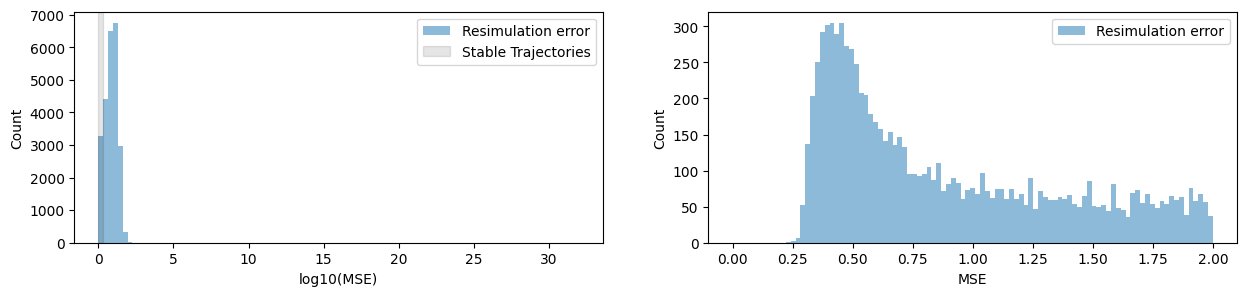

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

zoom_until = 2

axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 100), alpha=0.5, label='Resimulation error');
axes[0].axvspan(0, np.log10(zoom_until), alpha=0.1, color='k', label='Stable Trajectories')

axes[0].set_xlabel('log10(MSE)')
axes[0].set_ylabel('Count')

axes[0].legend()

axes[1].hist(X_errors.flatten(), bins=np.linspace(0, zoom_until, 100), alpha=0.5, label='Resimulation error');

axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Count')

axes[1].legend()

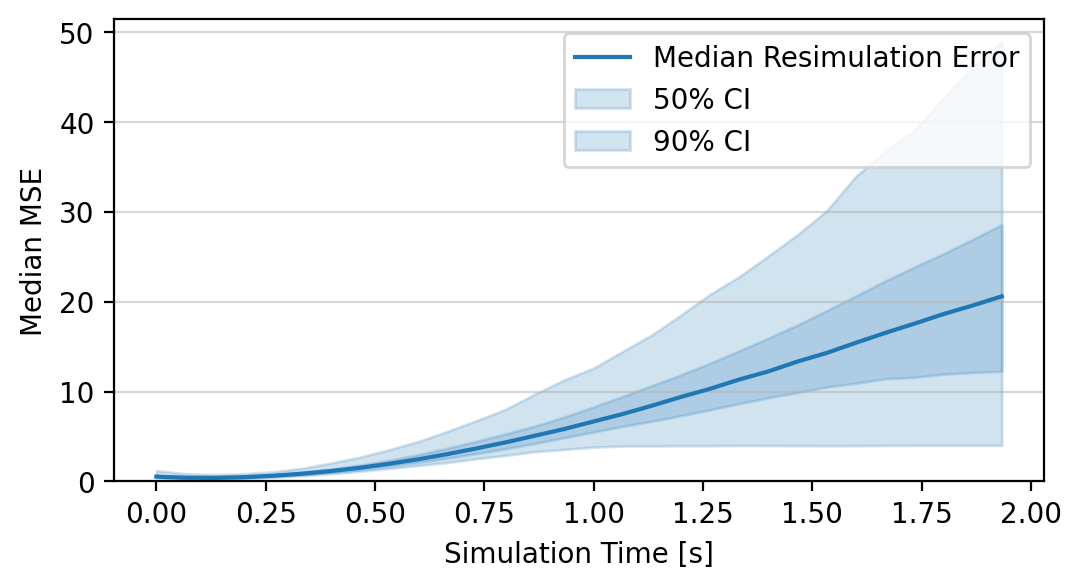

In [17]:
# Show the median resimulation error over simulation time
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=200)

ax.plot(np.arange(0, T, dt), np.nanmedian(X_errors, axis=0), label='Median Resimulation Error')
ax.fill_between(np.arange(0, T, dt), *np.nanpercentile(X_errors, [25, 75], axis=0), alpha=0.2, color='C0', label='50% CI')
ax.fill_between(np.arange(0, T, dt), *np.nanpercentile(X_errors, [5, 95], axis=0), alpha=0.2, color='C0', label='90% CI')
ax.set_ylim(0, None)

ax.set_xlabel('Simulation Time [s]')
ax.set_ylabel('Median MSE')
ax.legend()
ax.grid(axis='y', alpha=0.5)

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation_error.png'), bbox_inches='tight')

## Impact

In [18]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [19]:
true_impact_indices = np.where(np.diff((X[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X[true_impact_indices[0], true_impact_indices[1]]

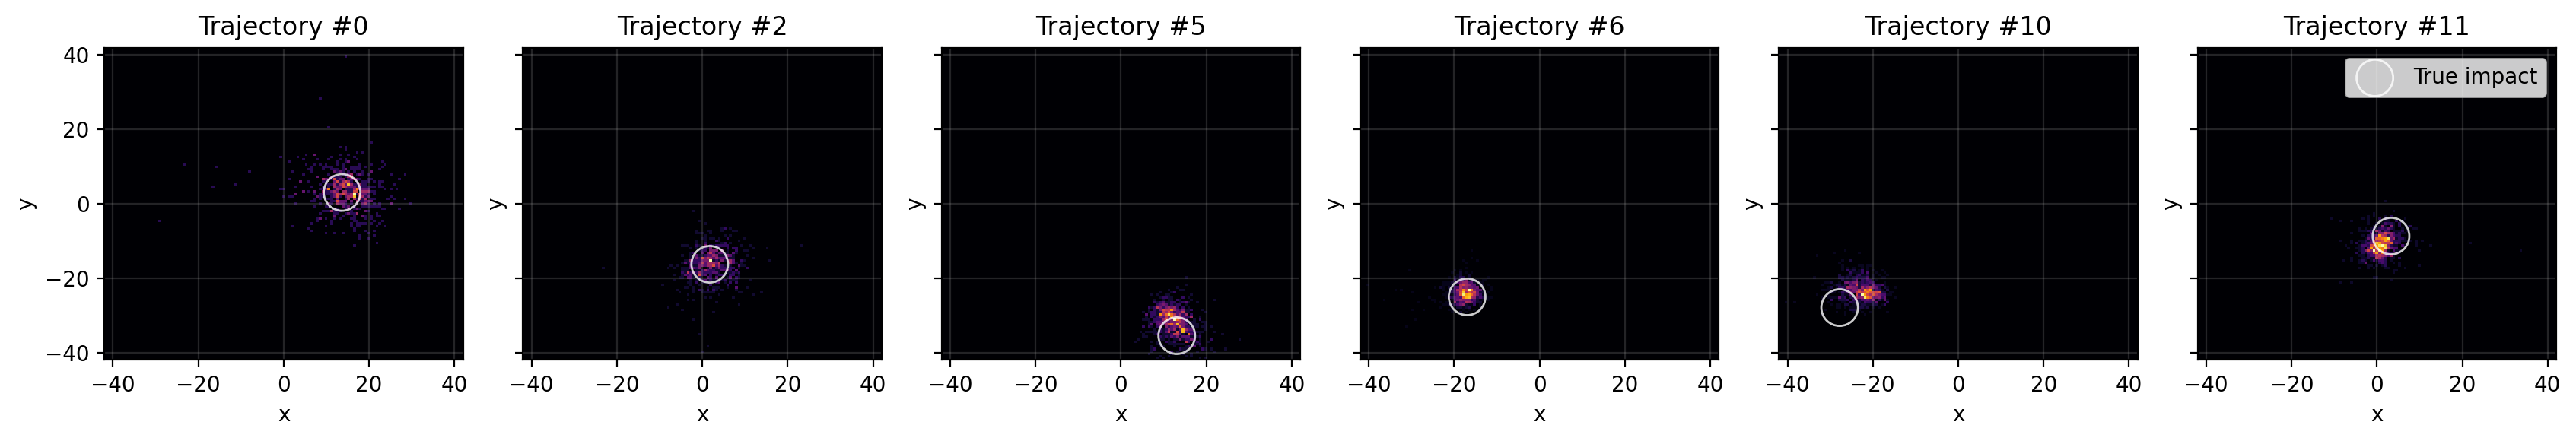

In [20]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, axes = plt.subplots(1, 6, figsize=(17, 3), sharey=True, dpi=200)

for i, (show_index, ax) in enumerate(zip(true_impact_indices[0], axes)):
    X_val_impact_position = X[show_index, true_impact_indices[1][np.where(true_impact_indices[0] == show_index)[0]][0], :]

    ax.hist2d(X_resimulation_impact_positions[show_index][:, 0], X_resimulation_impact_positions[show_index][:, 1], bins=np.linspace(-42, 42, 128), cmap='inferno');
    ax.scatter(X_val_impact_position[0], X_val_impact_position[1], s=300, marker='o', label='True impact', facecolors='none', edgecolors='white', alpha=0.8);
    ax.grid(axis='both', alpha=0.2);
    ax.set_xlabel('x');
    ax.set_ylabel('y');
    ax.set_title(f'Trajectory #{show_index}')

ax.legend();

fig.tight_layout()

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation_impact_heatmap.png'))

## Resimulations

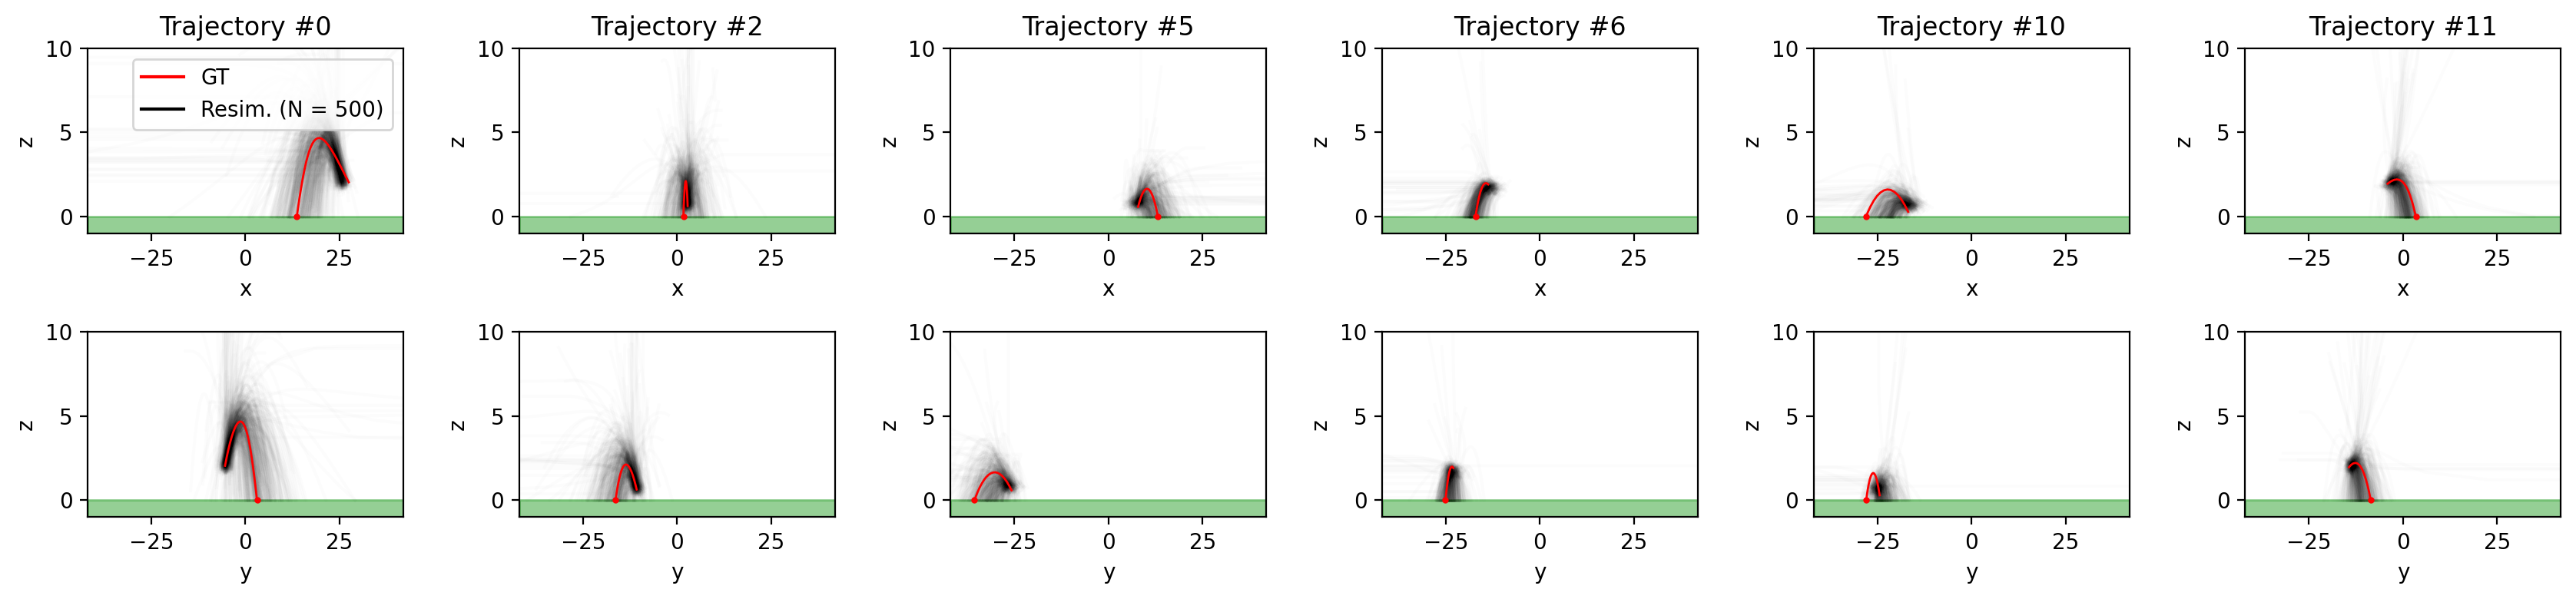

In [21]:
fig, axes = plt.subplots(2, 6, figsize=(17, 4), dpi=200)

n_trajectories = 500
max_time = 1000

for i, (ax_row, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    for show_index, ax in zip(true_impact_indices[0], ax_row):
        ax.plot(X_resimulation[show_index, :n_trajectories, :max_time, i].T, X_resimulation[show_index, :n_trajectories, :max_time, 2].T, alpha=0.01, color='black');
        ax.plot(X[show_index, :, i], X[show_index, :, 2], label='Ground Truth', color='red', linewidth=1);
        ax.plot(X[show_index, -1, i], X[show_index, -1, 2], marker='o', markersize=2, color='red');
        ax.set_xlim(-42, 42)
        ax.set_ylim(-1, 10)
        ax.set_xlabel(ax_name);
        ax.set_ylabel('z');
        ax.axhspan(-2, 0, alpha=0.5, color='tab:green');

        if i == 0:
            ax.set_title(f'Trajectory #{show_index}')


# Add an additional legend for resimulation with red and black lines
red_patch = plt.Line2D([0], [0], color='red', label='GT')
black_patch = plt.Line2D([0], [0], color='black', label=f'Resim. (N = {n_trajectories})')
axes[0, 0].legend(handles=[red_patch, black_patch], loc='upper right');

fig.tight_layout()

plt.savefig(os.path.join(get_dir('results', f'{MODEL_NAME}', 'figures', create=True), 'resimulation.png'), dpi=200)

## Calcualate model score

### Trajectory

In [ ]:
X_error_copy_perm = X_error_copy.transpose(1, 0, 2, 3)
print(f'{X_error_copy_perm.shape=}')

X_error_copy_perm.shape=(1000, 100, 30, 3)


In [ ]:
error_traj = np.median(X_error_copy_perm, axis=(1, 2, 3))
print(f'{error_traj.shape=}')

error_traj.shape=(1000,)


Number of elements in error_traj:  1000 Number of elements in error_traj_mod:  1000
Mean trajectory error:  44.945


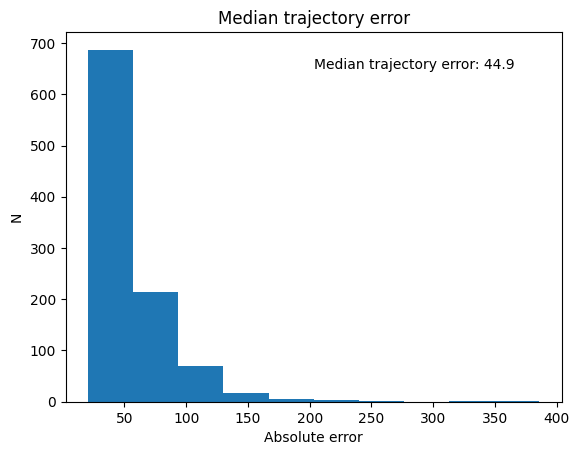

In [ ]:
error_traj_mod = error_traj[error_traj < 1e20]
print("Number of elements in error_traj: ", len(error_traj), "Number of elements in error_traj_mod: ", len(error_traj_mod))
error_tot_traj = round(np.median(error_traj_mod),3)
print("Mean trajectory error: ", error_tot_traj)

plt.hist(error_traj_mod, bins=10)
plt.xlabel('Absolute error')
plt.ylabel('N')
plt.text(0.5, 0.9, f"Median trajectory error: {error_tot_traj:.3}", transform=plt.gca().transAxes)
plt.title('Median trajectory error')
plt.show()


### Impact - BROKEN AHHHHHHHHHHHHHHHHHh i am going crazy

In [ ]:
X_resimulation_perm = X_resimulation.transpose(1, 0, 2, 3)
print(f'{X_resimulation_perm.shape=}')

X_resimulation_perm.shape=(1000, 100, 30, 3)


In [ ]:
impact_indices = [np.where(np.diff((X_resimulation_perm[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation_perm.shape[0])]

In [ ]:
mean_impact = np.zeros((len(impact_indices), 2))

for sim_num in range(len(impact_indices)):
    for i in range(len(impact_indices[sim_num][0])):
        mean_impact[sim_num, 0] += impact_indices[sim_num][0][i]
        mean_impact[sim_num, 1] += impact_indices[sim_num][1][i]

    mean_impact[sim_num, 0] /= len(impact_indices[sim_num][0])
    mean_impact[sim_num, 1] /= len(impact_indices[sim_num][1])

print(f'{mean_impact.shape=}')

mean_impact.shape=(1000, 2)


In [ ]:
X_trajectories[22][29]

array([ -0.79738716, -15.11917101,   3.29766588])

In [ ]:
def find_sign_change_idx(sample):
    for i in range(len(sample) - 1):
        if sample[i][2] > 0 and sample[i + 1][2] < 0:
            return i
        
    print("FUCK")
    return None

In [ ]:
coordinates = []

for sample in X_trajectories:
    idx = find_sign_change_idx(sample)
    if idx is not None:
        x, y, _ = sample[idx]  # Extracting x and y coordinates
        coordinates.append((x, y))

FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK
FUCK


In [ ]:
print(f'{len(coordinates)=}')

len(coordinates)=21


In [ ]:
true_impact_indices = np.where(np.diff((X_trajectories[:, :, -1] > 0).astype(int)) == -1)
print(f'{len(true_impact_indices)=}')
print(f'{type(true_impact_indices[0])=}')
print(f'{true_impact_indices[0].shape=}')

len(true_impact_indices)=2
type(true_impact_indices[0])=<class 'numpy.ndarray'>
true_impact_indices[0].shape=(403,)


In [ ]:
X_val_impact_positions = X_trajectories[true_impact_indices[0], true_impact_indices[1]]
print(f'{X_val_impact_positions.shape=}')
print(f'{X_val_impact_positions[0].shape=}')

X_val_impact_positions.shape=(403, 3)
X_val_impact_positions[0].shape=(3,)
